In [1]:
from sklearn.model_selection import train_test_split
import torch
import pandas as pd

In [2]:
# 检查是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 构造数据集

In [3]:
# 读取数据集
data_path = '../datasets/chinese_movie_reviews/chinese_movie_reviews_datasets.jsonl'
df = pd.read_json(data_path, orient='records', lines=True)

# star > 3标记为 1，star < 3 标记为0。去除star==3的数据，去除star避免中性评论干扰模型
df['label'] = df['stars'].apply(lambda x: 1 if x > 3 else (0 if x < 3 else None))
df = df.dropna(subset=['label'])
df['label'] = df['label'].astype(int)  # 转换为整数类型

print(f'数据数量{len(df)}')
print(df.sample(5))

数据数量333248
                                                  content  stars  label
67672   杰森斯坦森的片儿看起来都比较过瘾，剧情其次哈哈！！剪辑比较失败好多交代不明白或者草草略过，但...      4      1
14223                                       小时候看的~当时惊为天人~      4      1
209125  谈及尺八与长城间相似的温柔和孤独，小凑昭尚长城之上于已故友人间的共鸣，没有苦涩，更像宽慰，哀...      5      1
63065                                           火山爆发，极限逃生      4      1
140220  3D cinema class screening. 2D转3D好像没有什么必要，不过结尾的...      4      1


In [4]:
# 计算每条文本的长度
sentence_lengths = df["content"].apply(lambda x: len(x))  # 计算每条文本的词数（已经分词）
# 计算最大长度和平均长度
max_length = sentence_lengths.max()
avg_length = sentence_lengths.mean()
print(f"最大文本长度：{max_length}")
print(f"平均文本长度：{avg_length:.2f}")

df.sample(5)

最大文本长度：1953
平均文本长度：62.20


,content,stars,label
175591,这套光盘至今还在~,5,1
347259,看到最后的时候笑了。就这？非常嫌疑犯？,2,0
246612,冲着男主的那张帅脸亲上去！,4,1
111445,非常好看的一部电影，很有武侠味道！！！真的怀念以前的古装剧,4,1
65906,Sofía Vergara~~~,4,1


In [5]:
# 划分训练集和测试集 (这里使用90/10划分)
train_df, test_df = train_test_split(df, test_size=0.1, stratify=df['label'])

print(f"训练集大小: {len(train_df)}")
print(f"测试集大小: {len(test_df)}")

训练集大小: 299923
测试集大小: 33325


In [6]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
import os

# 定义分词器路径 这里使用 Bert 的分词器
# 需提前下载好分词器文件
tokenizer_path = '../models/3_Transformer_Sentiment_Classification/bert-base-chinese'
tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
    
max_len = 128

# 创建自定义Dataset
class MovieReviewDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = str(self.reviews[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True, # 添加 [CLS]（用于分类）和 [SEP]（分隔符）
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length', # 短序列填充到 max_len
            truncation=True,      # 长序列截断到 max_len
            return_attention_mask=True,
            return_tensors='pt',  # 返回PyTorch张量
        )

        return {
            # 'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = MovieReviewDataset(train_df.content.to_numpy(), train_df.label.to_numpy(), tokenizer, max_len)
test_dataset = MovieReviewDataset(test_df.content.to_numpy(), test_df.label.to_numpy(), tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

## 定义模型

In [7]:
import torch.nn as nn
import math

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_encoder_layers, ff_dim, num_classes,
                     max_len=512, dropout_rate=0.1):
        """
        初始化 Transformer 分类器
        
        Args:
            vocab_size (int): 词汇表大小（tokenizer.vocab_size）。
            embed_dim (int): 词嵌入和 Transformer 的维度（d_model）。
            num_heads (int): 多头注意力机制的头数，必须能整除 embed_dim。
            num_encoder_layers (int): Transformer Encoder 的层数。
            ff_dim (int): 前馈网络中间层的维度（通常为 embed_dim 的 2-4 倍）。
            num_classes (int): 分类任务的类别数（2 表示正/负）。
            max_len (int): 最大序列长度，用于位置嵌入。
            dropout_rate (float): Dropout 比率，用于正则化。
        """
        super().__init__()
        self.embed_dim = embed_dim
        # 词嵌入层，将 token ID 映射到 embed_dim 维向量
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        # 可学习的位置嵌入，为每个位置生成 embed_dim 维向量
        self.positional_embedding = nn.Embedding(max_len, embed_dim)

        # 定义单个 Transformer Encoder 层
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,              # 模型维度
            nhead=num_heads,                # 注意力头数
            dim_feedforward=ff_dim,         # 前馈网络中间层维度
            dropout=dropout_rate,            # Dropout 比率
            batch_first=True,               # 输入/输出形状为 (batch, seq, feature)，适配常见数据格式
            activation='gelu'               # 使用 GELU 激活函数，相比 ReLU 更平滑，有助于梯度流动
        )

        # 堆叠多个 Transformer Encoder 层
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_encoder_layers,
            norm=nn.LayerNorm(embed_dim)    # 显式添加 LayerNorm，规范化输出
        )

        self.dropout = nn.Dropout(dropout_rate)
        
        # 分类头：将 [CLS] token 的输出（embed_dim 维）映射到 num_classes 维
        self.fc_out = nn.Linear(embed_dim, num_classes)

        self.max_len = max_len # 存储最大序列长度，供位置编码使用

        self._init_weights()

    def _init_weights(self):
        """
        初始化模型权重，使用 Xavier Uniform 初始化，适合 Transformer 模型。
        避免初始权重过大或过小，加速收敛。
        """
        for p in self.parameters():
            if p.dim() > 1:  # 仅对二维以上参数（如线性层、嵌入层）应用
                nn.init.xavier_uniform_(p)
            # 对嵌入层可额外应用正态初始化
            elif p.dim() == 2 and 'embedding' in p.name:
                nn.init.normal_(p, mean=0.0, std=0.02)

    def forward(self, input_ids, attention_mask):
        """
        前向传播，处理输入序列并输出分类 logits。

        Args:
            input_ids (torch.Tensor): 形状 (batch_size, seq_len)，词的 ID。
            attention_mask (torch.Tensor): 形状 (batch_size, seq_len)，1 表示有效 token，0 表示 padding。

        Returns:
            torch.Tensor: 形状 (batch_size, num_classes)，分类 logits。
        """
        seq_len = input_ids.size(1)  # 获取序列长度

        # 1. 词嵌入
        token_embeds = self.token_embedding(input_ids)  # (batch_size, seq_len, embed_dim)
        token_embeds = token_embeds * math.sqrt(self.embed_dim) # 缩放嵌入，稳定训练

        # 2. 位置编码
        # 生成位置索引：(batch_size, seq_len)，每个样本重复 0 到 seq_len-1
        positions = torch.arange(0, seq_len, device=input_ids.device).unsqueeze(0).repeat(input_ids.size(0), 1)
        position_embeds = self.positional_embedding(positions)  # (batch_size, seq_len, embed_dim)
        
        # 词嵌入与位置嵌入相加
        x = token_embeds + position_embeds
        x = self.dropout(x)  # 在嵌入后应用 Dropout，增强鲁棒性

        # Transformer Encoder需要 src_key_padding_mask
        # attention_mask: 1是token, 0是padding.
        # src_key_padding_mask: True表示该位置是padding, 需要被mask掉.
        src_key_padding_mask = (attention_mask == 0)  # (batch_size, seq_len)

        # 3. Transformer Encoder
        # 输入形状: (batch_size, seq_len, embed_dim)
        encoder_output = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)
        # encoder_output shape: (batch_size, seq_len, embed_dim)

        # 4. 分类
        # 通常使用第一个token ([CLS] token)的输出来进行分类
        cls_output = encoder_output[:, 0, :]  # (batch_size, embed_dim)
        # 或者，可以对所有token的输出进行平均池化或最大池化
        # cls_output = encoder_output.mean(dim=1) # 平均池化

        cls_output = self.dropout(cls_output)
        logits = self.fc_out(cls_output)  # (batch_size, num_classes)

        return logits

# 定义模型超参数
VOCAB_SIZE = tokenizer.vocab_size  # 从之前加载的 BERT 分词器获取
EMBED_DIM = 256                   # 嵌入维度，较小以减少计算量（BERT 常用 768）
NUM_HEADS = 8                     # 多头注意力头数，需满足 embed_dim % num_heads == 0
NUM_ENCODER_LAYERS = 4            # Encoder 层数，平衡性能与计算成本
FF_DIM = 512                      # 前馈网络中间层维度，通常为 embed_dim 的 2-4 倍
NUM_CLASSES = 2                   # 分类任务的类别数（正/负情感）
DROPOUT_RATE = 0.1                # Dropout 比率，防止过拟合


model = TransformerClassifier(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    ff_dim=FF_DIM,
    num_classes=NUM_CLASSES,
    max_len=max_len, # 从之前的配置中获取
    dropout_rate=DROPOUT_RATE
)
model = model.to(device)

In [8]:
# 查看模型结构
# 打印模型参数总数和可训练参数总数
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())  # 所有参数数量
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)  # 需要训练的参数数量
    print(f"模型总参数数量: {total_params:,}")
    print(f"模型可训练参数数量: {trainable_params:,}")

print(model)
count_parameters(model)

TransformerClassifier(
  (token_embedding): Embedding(21128, 256)
  (positional_embedding): Embedding(128, 256)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc_out): Linear(in_features=256, out_features=2, bias=True)

## 模型训练与评估

In [9]:
EPOCHS = 5
LEARNING_RATE = 2e-5

# AdamW 是 Adam 的变种，增加了权重衰减（weight decay）
optimizer = AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    eps=1e-8,                  # 防止除零的微小值，1e-8 是 Adam 的默认值
    weight_decay=0.01          # 添加权重衰减（L2 正则化），防止过拟合，0.01 是常见值
)

# 计算总训练步数
total_steps = len(train_loader) * EPOCHS

# 初始化学习率调度器
# get_linear_schedule_with_warmup 是一种常见的调度策略：
# 1. 在 warmup 阶段，学习率从 0 线性增加到初始学习率
# 2. 之后，学习率线性衰减到 0
scheduler = get_linear_schedule_with_warmup(
    optimizer,                          # 绑定的优化器
    num_warmup_steps=int(total_steps * 0.1),  # 预热步数，10% 的总步数，逐步增加学习率以稳定训练
    num_training_steps=total_steps      # 总训练步数，用于线性衰减
)
loss_fn = nn.CrossEntropyLoss().to(device)

D:\develop\anaconda\envs\pytorch\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
from tqdm import tqdm

# 训练函数
def train(dataloader, model, loss_fn, optimizer):
    model.train()  # 设置模型为训练模式
    
    running_loss = 0.0
    correct = 0
    total = 0

    # 使用 tqdm 包裹数据加载器，显示进度条
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for item in progress_bar:
        # 将数据移动到设备
        input_ids = item["input_ids"].to(device)
        attention_mask = item["attention_mask"].to(device)
        labels = item["labels"].to(device)

        # 前向传播
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, labels)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()  # 更新模型参数
        scheduler.step()

        # 统计指标
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 更新进度条描述
        progress_bar.set_postfix(lr=optimizer.param_groups[0]['lr'], loss=loss.item())
        
    scheduler.step()  # 更新学习率       

    accuracy = 100 * correct / total
    avg_loss = running_loss / len(dataloader)
    return avg_loss, accuracy

In [11]:
# 测试函数
def evaluate(dataloader, model, loss_fn):
    model.eval()  # 设置模型为评估模式
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # 关闭梯度计算
        progress_bar = tqdm(dataloader, desc="Evaluating", leave=False)
        for item in progress_bar:
            # 将数据移动到设备
            input_ids = item["input_ids"].to(device)
            attention_mask = item["attention_mask"].to(device)
            labels = item["labels"].to(device)
    
            # 前向传播
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, labels)

            # 统计指标
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # 更新进度条描述
            progress_bar.set_postfix(loss=loss.item())

    accuracy = 100 * correct / total
    avg_loss = running_loss / len(dataloader)
    return avg_loss, accuracy

In [12]:
# 开始训练

num_epochs = 5

train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    epoch_train_loss, epoch_train_acc = train(train_loader, model, loss_fn, optimizer)

    # 在测试集上评估
    epoch_test_loss, epoch_test_acc = evaluate(test_loader, model, loss_fn)

    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)
    # 打印训练和测试结果
    template = ('Epoch:{:2d}, Train_acc:{:.1f}%, Train_loss:{:.3f}, Test_acc:{:.1f}%，Test_loss:{:.3f}')
    print(template.format(epoch+1, epoch_train_acc, epoch_train_loss, epoch_test_acc, epoch_test_loss))

print("训练完成!")

Epoch 1/5


Training:   0%|                                                                               | 0/9373 [00:00<?, ?it/s]D:\develop\anaconda\envs\pytorch\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
Evaluating:   0%|                                                                             | 0/1042 [00:00<?, ?it/s]D:\develop\anaconda\envs\pytorch\lib\site-packages\torch\nn\modules\transformer.py:409: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\NestedTensorImpl.cpp:180.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


Epoch: 1, Train_acc:77.0%, Train_loss:0.519, Test_acc:80.8%，Test_loss:0.439
Epoch 2/5


Epoch: 2, Train_acc:81.0%, Train_loss:0.435, Test_acc:81.2%，Test_loss:0.439
Epoch 3/5


Epoch: 3, Train_acc:81.6%, Train_loss:0.423, Test_acc:81.4%，Test_loss:0.438
Epoch 4/5


Epoch: 4, Train_acc:82.1%, Train_loss:0.413, Test_acc:81.2%，Test_loss:0.439
Epoch 5/5


Epoch: 5, Train_acc:82.4%, Train_loss:0.406, Test_acc:81.5%，Test_loss:0.440
训练完成!


## 结果可视化

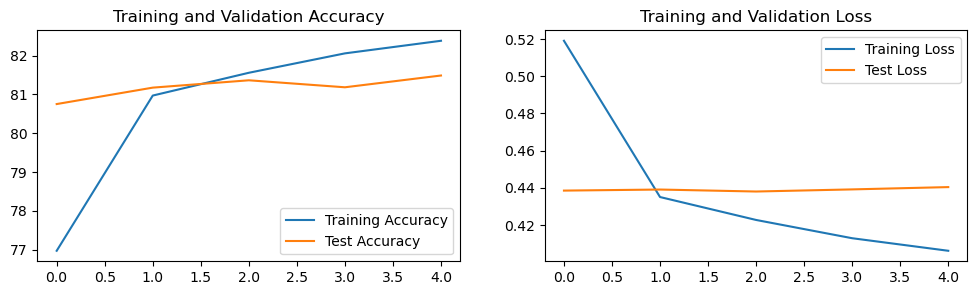

In [13]:
import matplotlib.pyplot as plt

epochs_range = range(num_epochs)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, test_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, test_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 保存模型

In [14]:
# 指定保存路径
save_dir = '../models/3_Transformer_Sentiment_Classification'

# 确保目录存在，如果不存在则创建
import os
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 保存模型
torch.save(model.state_dict(), os.path.join(save_dir, 'model_weights.pth'))

# # 加载模型参数
# model.load(torch.load(os.path.join(save_dir, 'model_weights.pth')))